# Staff Planning Problem

An insurance company InsurePlus wants you to help them with finding the optimal number of staff that they need for their insurance application approval process for the calendar year 2021. In the industry, the number of staffs is considered as a continuous variable. This is also called a Full-Time Equivalent (FTE) of the staff. In the industry, staff availability is predicted using a time-motion study. But in this case, you have been given fixed numbers for each month.

##### Importing libraries 

In [2]:
import pandas as pd
import numpy as np

In [3]:
import math
from pyomo.environ import *

In [4]:
from __future__ import division
from pyomo.opt import SolverFactory

##### Reading the data from Excel workbook


In [5]:
# Dataframe for the Staff information
staff_d = pd.read_excel("Staffing+Data.xlsx", sheet_name ='StaffAvailability')

In [6]:
# Dataframe for the Staffing Cost related information
cost_d = pd.read_excel("Staffing+Data.xlsx", sheet_name ='Cost')

In [7]:
# Dataframe for the Service Rate related information
serve_rate = pd.read_excel("Staffing+Data.xlsx", sheet_name ='ServiceRate')

In [8]:
# Dataframe for the Demand related information
mg_dem_dist = pd.read_excel("Staffing+Data.xlsx", sheet_name ='DemandData')

##### Checking sample data given

In [9]:
staff_d.head()

,State,Month,LB,UB,StaffAvPer
0,A,Jan,0.70,0.90,0.81
1,A,Feb,0.65,0.85,0.76
2,A,Mar,0.70,0.80,0.75
3,A,Apr,0.75,0.85,0.80
4,A,May,0.70,0.85,0.78


In [10]:
cost_d.head()

,State,Month,AnnualSalary,MonthlySalary,UnitOutSourceCost
0,A,Jan,60000,5000.0,180
1,A,Feb,60000,5000.0,180
2,A,Mar,60000,5000.0,180
3,A,Apr,60000,5000.0,180
4,A,May,60000,5000.0,180


In [11]:
serve_rate.head()

,MgAppServedPerMonth
0,40


In [12]:
mg_dem_dist.head()

,State,Month,Demand
0,A,Jan,5240
1,A,Feb,4878
2,A,Mar,5942
3,A,Apr,2297
4,A,May,1992


##### Data pre-processing 

Create the required Python data structures for indexes and parameters

In [13]:
# Creating a Dictionary "Demand" with index as 'State' and 'Month' and Value as "Demand" column from the "mg_dem_dist"(Demand distribution) Dataframe
Demand = mg_dem_dist.set_index(['State','Month'])['Demand'].to_dict()
Demand

{('A', 'Jan'): 5240,
 ('A', 'Feb'): 4878,
 ('A', 'Mar'): 5942,
 ('A', 'Apr'): 2297,
 ('A', 'May'): 1992,
 ('A', 'Jun'): 2275,
 ('A', 'Jul'): 5334,
 ('A', 'Aug'): 3371,
 ('A', 'Sep'): 3759,
 ('A', 'Oct'): 3529,
 ('A', 'Nov'): 4284,
 ('A', 'Dec'): 5183,
 ('B', 'Jan'): 4927,
 ('B', 'Feb'): 2628,
 ('B', 'Mar'): 2974,
 ('B', 'Apr'): 2338,
 ('B', 'May'): 4020,
 ('B', 'Jun'): 3147,
 ('B', 'Jul'): 4271,
 ('B', 'Aug'): 2620,
 ('B', 'Sep'): 4517,
 ('B', 'Oct'): 4155,
 ('B', 'Nov'): 3137,
 ('B', 'Dec'): 4227,
 ('C', 'Jan'): 1162,
 ('C', 'Feb'): 1967,
 ('C', 'Mar'): 1898,
 ('C', 'Apr'): 2261,
 ('C', 'May'): 2030,
 ('C', 'Jun'): 1642,
 ('C', 'Jul'): 2489,
 ('C', 'Aug'): 2496,
 ('C', 'Sep'): 922,
 ('C', 'Oct'): 2421,
 ('C', 'Nov'): 963,
 ('C', 'Dec'): 1998}

In [14]:
# Creating a Dictionary "FTE_Income" with index as'State' and 'Month' and Value as "MonthlySalary" column from the "cost_d" Dataframe
FTE_Income = cost_d.set_index(['State','Month'])['MonthlySalary'].to_dict()
FTE_Income

{('A', 'Jan'): 5000.0,
 ('A', 'Feb'): 5000.0,
 ('A', 'Mar'): 5000.0,
 ('A', 'Apr'): 5000.0,
 ('A', 'May'): 5000.0,
 ('A', 'Jun'): 5000.0,
 ('A', 'Jul'): 5000.0,
 ('A', 'Aug'): 5000.0,
 ('A', 'Sep'): 5000.0,
 ('A', 'Oct'): 5000.0,
 ('A', 'Nov'): 5000.0,
 ('A', 'Dec'): 5000.0,
 ('B', 'Jan'): 4583.333333333333,
 ('B', 'Feb'): 4583.333333333333,
 ('B', 'Mar'): 4583.333333333333,
 ('B', 'Apr'): 4583.333333333333,
 ('B', 'May'): 4583.333333333333,
 ('B', 'Jun'): 4583.333333333333,
 ('B', 'Jul'): 4583.333333333333,
 ('B', 'Aug'): 4583.333333333333,
 ('B', 'Sep'): 4583.333333333333,
 ('B', 'Oct'): 4583.333333333333,
 ('B', 'Nov'): 4583.333333333333,
 ('B', 'Dec'): 4583.333333333333,
 ('C', 'Jan'): 4416.666666666667,
 ('C', 'Feb'): 4416.666666666667,
 ('C', 'Mar'): 4416.666666666667,
 ('C', 'Apr'): 4416.666666666667,
 ('C', 'May'): 4416.666666666667,
 ('C', 'Jun'): 4416.666666666667,
 ('C', 'Jul'): 4416.666666666667,
 ('C', 'Aug'): 4416.666666666667,
 ('C', 'Sep'): 4416.666666666667,
 ('C', 'Oc

In [15]:
# Creating a Dictionary "Unit_OutSource_Cost" with index as 'State' and 'Month' and Value as "UnitOutSourceCost" column from the "cost_d" Dataframe
Unit_OutSource_Cost = cost_d.set_index(['State','Month'])['UnitOutSourceCost'].to_dict()
Unit_OutSource_Cost

{('A', 'Jan'): 180,
 ('A', 'Feb'): 180,
 ('A', 'Mar'): 180,
 ('A', 'Apr'): 180,
 ('A', 'May'): 180,
 ('A', 'Jun'): 180,
 ('A', 'Jul'): 180,
 ('A', 'Aug'): 180,
 ('A', 'Sep'): 180,
 ('A', 'Oct'): 180,
 ('A', 'Nov'): 180,
 ('A', 'Dec'): 180,
 ('B', 'Jan'): 150,
 ('B', 'Feb'): 150,
 ('B', 'Mar'): 150,
 ('B', 'Apr'): 150,
 ('B', 'May'): 150,
 ('B', 'Jun'): 150,
 ('B', 'Jul'): 150,
 ('B', 'Aug'): 150,
 ('B', 'Sep'): 150,
 ('B', 'Oct'): 150,
 ('B', 'Nov'): 150,
 ('B', 'Dec'): 150,
 ('C', 'Jan'): 160,
 ('C', 'Feb'): 160,
 ('C', 'Mar'): 160,
 ('C', 'Apr'): 160,
 ('C', 'May'): 160,
 ('C', 'Jun'): 160,
 ('C', 'Jul'): 160,
 ('C', 'Aug'): 160,
 ('C', 'Sep'): 160,
 ('C', 'Oct'): 160,
 ('C', 'Nov'): 160,
 ('C', 'Dec'): 160}

In [16]:
# Staff Availability for serving the Insurance Applications 
StaffAv_M = staff_d.set_index(['State','Month'])['StaffAvPer'].to_dict()
StaffAv_M

{('A', 'Jan'): 0.81,
 ('A', 'Feb'): 0.76,
 ('A', 'Mar'): 0.75,
 ('A', 'Apr'): 0.8,
 ('A', 'May'): 0.78,
 ('A', 'Jun'): 0.73,
 ('A', 'Jul'): 0.68,
 ('A', 'Aug'): 0.76,
 ('A', 'Sep'): 0.81,
 ('A', 'Oct'): 0.73,
 ('A', 'Nov'): 0.68,
 ('A', 'Dec'): 0.65,
 ('B', 'Jan'): 0.81,
 ('B', 'Feb'): 0.76,
 ('B', 'Mar'): 0.75,
 ('B', 'Apr'): 0.8,
 ('B', 'May'): 0.78,
 ('B', 'Jun'): 0.73,
 ('B', 'Jul'): 0.68,
 ('B', 'Aug'): 0.76,
 ('B', 'Sep'): 0.81,
 ('B', 'Oct'): 0.73,
 ('B', 'Nov'): 0.68,
 ('B', 'Dec'): 0.65,
 ('C', 'Jan'): 0.81,
 ('C', 'Feb'): 0.76,
 ('C', 'Mar'): 0.75,
 ('C', 'Apr'): 0.8,
 ('C', 'May'): 0.78,
 ('C', 'Jun'): 0.73,
 ('C', 'Jul'): 0.68,
 ('C', 'Aug'): 0.76,
 ('C', 'Sep'): 0.81,
 ('C', 'Oct'): 0.73,
 ('C', 'Nov'): 0.68,
 ('C', 'Dec'): 0.65}

In [17]:
# Staff Availability for serving the Insurance Applications (LB)
StaffAv_LB = staff_d.set_index(['State','Month'])['LB'].to_dict()
StaffAv_LB

{('A', 'Jan'): 0.7,
 ('A', 'Feb'): 0.65,
 ('A', 'Mar'): 0.7,
 ('A', 'Apr'): 0.75,
 ('A', 'May'): 0.7,
 ('A', 'Jun'): 0.65,
 ('A', 'Jul'): 0.6,
 ('A', 'Aug'): 0.65,
 ('A', 'Sep'): 0.7,
 ('A', 'Oct'): 0.65,
 ('A', 'Nov'): 0.6,
 ('A', 'Dec'): 0.6,
 ('B', 'Jan'): 0.7,
 ('B', 'Feb'): 0.65,
 ('B', 'Mar'): 0.7,
 ('B', 'Apr'): 0.75,
 ('B', 'May'): 0.7,
 ('B', 'Jun'): 0.65,
 ('B', 'Jul'): 0.6,
 ('B', 'Aug'): 0.65,
 ('B', 'Sep'): 0.7,
 ('B', 'Oct'): 0.65,
 ('B', 'Nov'): 0.6,
 ('B', 'Dec'): 0.6,
 ('C', 'Jan'): 0.7,
 ('C', 'Feb'): 0.65,
 ('C', 'Mar'): 0.7,
 ('C', 'Apr'): 0.75,
 ('C', 'May'): 0.7,
 ('C', 'Jun'): 0.65,
 ('C', 'Jul'): 0.6,
 ('C', 'Aug'): 0.65,
 ('C', 'Sep'): 0.7,
 ('C', 'Oct'): 0.65,
 ('C', 'Nov'): 0.6,
 ('C', 'Dec'): 0.6}

In [18]:
# Staff Availability for serving the Insurance Applications (UB)
StaffAv_UB = staff_d.set_index(['State','Month'])['UB'].to_dict()
StaffAv_UB

{('A', 'Jan'): 0.9,
 ('A', 'Feb'): 0.85,
 ('A', 'Mar'): 0.8,
 ('A', 'Apr'): 0.85,
 ('A', 'May'): 0.85,
 ('A', 'Jun'): 0.8,
 ('A', 'Jul'): 0.75,
 ('A', 'Aug'): 0.85,
 ('A', 'Sep'): 0.9,
 ('A', 'Oct'): 0.8,
 ('A', 'Nov'): 0.75,
 ('A', 'Dec'): 0.7,
 ('B', 'Jan'): 0.9,
 ('B', 'Feb'): 0.85,
 ('B', 'Mar'): 0.8,
 ('B', 'Apr'): 0.85,
 ('B', 'May'): 0.85,
 ('B', 'Jun'): 0.8,
 ('B', 'Jul'): 0.75,
 ('B', 'Aug'): 0.85,
 ('B', 'Sep'): 0.9,
 ('B', 'Oct'): 0.8,
 ('B', 'Nov'): 0.75,
 ('B', 'Dec'): 0.7,
 ('C', 'Jan'): 0.9,
 ('C', 'Feb'): 0.85,
 ('C', 'Mar'): 0.8,
 ('C', 'Apr'): 0.85,
 ('C', 'May'): 0.85,
 ('C', 'Jun'): 0.8,
 ('C', 'Jul'): 0.75,
 ('C', 'Aug'): 0.85,
 ('C', 'Sep'): 0.9,
 ('C', 'Oct'): 0.8,
 ('C', 'Nov'): 0.75,
 ('C', 'Dec'): 0.7}

In [19]:
# No of applications (Employee is working 100%)
FTE_AppServeRate = serve_rate.iloc[0,0]
FTE_AppServeRate

40

In [20]:
# CS Index
Bank_loc = cost_d['State'].unique()
Month = cost_d['Month'].unique()

# Question 1

The company wants to know the optimised staffing recommendations for the business case described. 
Write the mathematical model for the deterministic optimisation problem. Define and explain your decision variables, objective function and the constraint. (Hint: Use months of the year as the model timeline).



#### InsurePlus is looking to optimise the cost for staffing plan <br> So according to it, we will have following mathematical model

####  Data given:

3 locations - A, B, C <br> 
Demand data available - statewise and monthwise <br> 
Resources for the Full Time Employees, Outsourced Application <br> 
Staff availability - both statewise and monthwise <br> 
Staff Annual Salary data - statewise and monthwise <br> 
Cost for outsourcing per application - monthwise and statewise <br> 
Outsourcing restriction at state A & B @ 30% & 40%  respectively


### Mathematical formulation:

#### Index: 
i = State <br>
j = Month

#### Parameters: 
Demand = Demand(i,j) <br>
Staff Availability Percentage = StaffAv(i,j) <br>
FTESalary = FTESalary(i,j) <br>
FTEAppServeRate = (No. of Application / Month) <br>
Unit Outsource Cost = UnitCost(i,j) 
 
#### Decision Variables:
FTE Equivalent at any location, month (Continuous Variable) = X(i,j) <br>
OutSource Application Quantity in a month (Integer) = Y(i,j) 
                    




**Note:** You can write the mathematical formulation directly in your report.

# Question 2

Code the problem is Python and use any optimization package to solve it. Add comments to your code to explain each step. 

#### Expected output:

Create a data frame containing the number of outsourced applications  and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. 

In [21]:
# Creating a model instance

# Defining model object
model = ConcreteModel()

##### Defining Pyomo sets, Parameters, Decision Variables, Constraints and the OBJECTIVE

In [22]:
# Pyomo Sets
# i is for locations of bank in states, j for the Months
model.i = Set(initialize = Bank_loc.tolist(),doc='States')
model.j = Set(initialize = Month.tolist(),doc='Months')

In [23]:
# The Parameters 
model.demand = Param(model.i,model.j,initialize = Demand,doc='Demand')
model.sa = Param(model.i, model.j, initialize=StaffAv_M, doc='StaffAvPercent')
model.s = Param(model.i, model.j, initialize=FTE_Income, doc='FTE Salary')
model.oc = Param(model.i, model.j, initialize=Unit_OutSource_Cost, doc='UnitSourceCost')
model.r = Param(initialize=FTE_AppServeRate, doc='FTE App Serve Rate')

In [24]:
# Decision variables
model.x = Var(model.i,model.j,domain = NonNegativeReals, doc='No of FTE')
model.y = Var(model.i,model.j,domain = NonNegativeIntegers,doc='No of Outsource App')

In [25]:
# Constraints

# Demand Constraint
def total_demand(model,i,j):
    return (model.x[i,j] * model.r * model.sa[i,j] + model.y[i,j] == model.demand[i,j])
            
model.demand_constraint = Constraint(model.i,model.j, rule=total_demand)

In [26]:
# Outsource Demand Constraints - # Regulalatory Constraints of A-30% and B-40%
model.regulatory_constraint = ConstraintList()
for j in model.j:
    for i in model.i:
        if i == 'A':
            model.regulatory_constraint.add(expr = model.y[i,j] <= 0.3 * model.demand[i,j])
        elif i == 'B':
            model.regulatory_constraint.add(expr = model.y[i,j] <= 0.4 * model.demand[i,j])

In [27]:
# Objective function

model.objective = Objective(expr = sum(sum(model.x[i,j]*model.s[i,j] + model.y[i,j]*model.oc[i,j] for i in model.i) for j in model.j), sense= minimize)

### THE RESULT

In [28]:
# Invoking the solver
result = SolverFactory('glpk').solve(model)
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 17962336.4487699
  Upper bound: 17962336.4487699
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.02290201187133789
# ----------------------------------------------------------
#   Solution Information
# ------------

In [29]:
#Print model details
model.pprint()

10 Set Declarations
    demand_constraint_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), ('B', 'Mar'), ('B', 'Apr'), ('B', 'May'), ('B', 'Jun'), ('B', 'Jul'), ('B', 'Aug'), ('B', 'Sep'), ('B', 'Oct'), ('B', 'Nov'), ('B', 'Dec'), ('C', 'Jan'), ('C', 'Feb'), ('C', 'Mar'), ('C', 'Apr'), ('C', 'May'), ('C', 'Jun'), ('C', 'Jul'), ('C', 'Aug'), ('C', 'Sep'), ('C', 'Oct'), ('C', 'Nov'), ('C', 'Dec')}
    demand_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B',

In [30]:
# Print the value of the objective function
optimum_cost = model.objective.expr()
optimum_cost

17962336.44876988

**`Checkpoint 1:`** Seems like the company has to spend around 17.9 m$ in total for the application approval process.

#### Dataframe for "THE RESULT"

In [31]:
Output_M = []

for i in Bank_loc:
    for j in Month:
        outs = model.y[i,j].value        #App_outsourced
        emp = model.x[i,j].value         #FTE
        cost = model.x[i,j].value*FTE_Income[i,j] + model.y[i,j].value*Unit_OutSource_Cost[i,j]
        demand = model.demand[i, j]
        avg_cost_per_app = round(cost/demand,2)
        Output_M.append([i,j,outs,emp,cost,demand,avg_cost_per_app])

In [32]:
Output_M_df = pd.DataFrame(Output_M, columns=['State', 'Month', 'Outsourced_App' , 'FTE', 'Cost', 'Demand', 'Average Cost'])

In [33]:
Output_M_df

,State,Month,Outsourced_App,FTE,Cost,Demand,Average Cost
0,A,Jan,0.0,161.728395,808641.975309,5240,154.32
1,A,Feb,0.0,160.460526,802302.631579,4878,164.47
2,A,Mar,0.0,198.066667,990333.333333,5942,166.67
3,A,Apr,0.0,71.781250,358906.250000,2297,156.25
4,A,May,0.0,63.846154,319230.769231,1992,160.26
5,A,Jun,0.0,77.910959,389554.794521,2275,171.23
6,A,Jul,1600.0,137.279412,974397.058824,5334,182.68
7,A,Aug,0.0,110.888158,554440.789474,3371,164.47
8,A,Sep,0.0,116.018519,580092.592593,3759,154.32
9,A,Oct,0.0,120.856164,604280.821918,3529,171.23


In [34]:
# Adding some extra columns for additional information/help

Output_M_df['UniqueID'] = Output_M_df.State + '-' + Output_M_df.Month              #Combining State&Month
Output_M_df['StaffAvPer'] = staff_d['StaffAvPer']
Output_M_df['FTE_Applications'] = Output_M_df.StaffAvPer * Output_M_df.FTE * 40

In [35]:
Output_M_df

,State,Month,Outsourced_App,FTE,Cost,Demand,Average Cost,UniqueID,StaffAvPer,FTE_Applications
0,A,Jan,0.0,161.728395,808641.975309,5240,154.32,A-Jan,0.81,5240.0
1,A,Feb,0.0,160.460526,802302.631579,4878,164.47,A-Feb,0.76,4878.0
2,A,Mar,0.0,198.066667,990333.333333,5942,166.67,A-Mar,0.75,5942.0
3,A,Apr,0.0,71.781250,358906.250000,2297,156.25,A-Apr,0.80,2297.0
4,A,May,0.0,63.846154,319230.769231,1992,160.26,A-May,0.78,1992.0
5,A,Jun,0.0,77.910959,389554.794521,2275,171.23,A-Jun,0.73,2275.0
6,A,Jul,1600.0,137.279412,974397.058824,5334,182.68,A-Jul,0.68,3734.0
7,A,Aug,0.0,110.888158,554440.789474,3371,164.47,A-Aug,0.76,3371.0
8,A,Sep,0.0,116.018519,580092.592593,3759,154.32,A-Sep,0.81,3759.0
9,A,Oct,0.0,120.856164,604280.821918,3529,171.23,A-Oct,0.73,3529.0


#### Total of Outsourced application and Optimum Staff Members

In [36]:
total_outsourced_app =  sum(Output_M_df['Outsourced_App'])
optimum_staff_members = round(Output_M_df['FTE_Applications'].mean(),1)
total_cost = sum(Output_M_df['Cost'])

In [37]:
total_demand =  sum(Output_M_df['Demand'])
average_cost_per_app = round(total_cost/total_demand,2)
total_outsourced_app_percentage = round((total_outsourced_app/total_demand)*100,1)
print("Total Outsourced Application: ", total_outsourced_app)
print("Total Demand Application: ", total_demand)
print("Optimum Staff Members : ", optimum_staff_members)

Total Outsourced Application:  20749.0
Total Demand Application:  113294
Optimum Staff Members :  2570.7


In [38]:
print("Total Outsourced Application % is : ", total_outsourced_app_percentage)

Total Outsourced Application % is :  18.3


#### Average cost per application

In [39]:
print("Average Cost per Application: ", average_cost_per_app)

Average Cost per Application:  158.55


In [40]:
# Writing the results in to an Excel sheet

from openpyxl import load_workbook
Output_M_df.to_excel("Output_M.xlsx", sheet_name='Output_M')

# Question 3

#### Worst-case and best-case analysis based on the staffs' availability.

Assuming that the distribution is the same across all the states,

#### 3.1 Worst case analysis 

- 3.1.1 What is the optimal number of staff members for the worst case? 

- 3.1.2 What is the percentage of outsourcing for the worst case? 

- 3.1.3 What is the average cost per application for the worst case?


#### 3.2 Best case analysis 

- 3.2.1 What is the optimal number of staff members for the best case? 

- 3.2.2 What is the percentage of outsourcing for the best case? 

- 3.2.3 What is the average cost per application for the best case?


#### Expected output:

For each of the subtasks (3.1 and 3.2) create a data frame containing the number of outsourced applications and the number of FTEs for each state-month combination. You can choose to have extra columns like staff availability, demand etc. in your dataframe apart from the ones mentioned earlier. Also, print the overall average percentage of outsourced applications and the overall average cost per application. 

### 3.1 Worst Case Analysis 

#### 3.1.1 Optimal number of staff members

In [41]:
# Model creation
model1 = ConcreteModel()

In [42]:
# Pyomo sets 

model1.i = Set(initialize=Bank_loc.tolist(),doc='States')   # Location of bank in States
model1.j = Set(initialize=Month.tolist(),doc='Months')      # Months

In [43]:
# Parameters

model1.demand = Param(model1.i,model1.j,initialize = Demand,doc='Demand')                         # Demand
model1.salb = Param(model1.i,model1.j,initialize = StaffAv_LB,doc = 'StaffLowerBoundPercent')     # Lower bound Staff Availability      
model1.s = Param(model1.i, model1.j, initialize=FTE_Income, doc='FTE Salary')                      # FTE Salary
model1.oc = Param(model1.i, model1.j, initialize=Unit_OutSource_Cost, doc='Unit Outsourcing Cost') # Unit Outsourcing Cost
model1.r = Param(initialize=FTE_AppServeRate, doc='FTE App Serve Rate')                            # Service Rate when 100% working

In [44]:
# Decision variables

model1.x = Var(model1.i,model1.j,domain = NonNegativeReals,doc='No of FTE')
model1.y = Var(model1.i,model1.j,domain = NonNegativeIntegers,doc='No of Outsource App')

In [45]:
# Constraints

# 1. Demand Constraint

def total_demand(m, i, j):
    return (m.x[i, j] * m.r * m.salb[i, j] + m.y[i, j] == m.demand[i, j])

model1.demand_constraint = Constraint(model1.i, model1.j, rule=total_demand)

In [46]:
# 2. Outsource Demand Constraints - Regulalatory Constraints of A-30% and B-40%

model1.regulatory_constraint = ConstraintList()
for j in model1.j:
    for i in model1.i:
        if i == 'A':
            model1.regulatory_constraint.add(expr = model1.y[i,j] <= 0.3*model1.demand[i,j])
        elif i == 'B':
            model1.regulatory_constraint.add(expr = model1.y[i,j] <= 0.4*model1.demand[i,j])

In [47]:
# Objective function
model1.value = Objective(expr = sum(sum(model1.x[i,j]*model1.s[i,j]+ model1.y[i,j]*model1.oc[i,j] for i in model1.i) for j in model1.j),sense= minimize)


#### THE RESULT - LB

In [48]:
# Invoking the solver
result_LB = SolverFactory('glpk').solve(model1)
result_LB.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 19599482.5167888
  Upper bound: 19599482.5167888
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.023833274841308594
# ----------------------------------------------------------
#   Solution Information
# -----------

In [49]:
model1.pprint()

10 Set Declarations
    demand_constraint_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), ('B', 'Mar'), ('B', 'Apr'), ('B', 'May'), ('B', 'Jun'), ('B', 'Jul'), ('B', 'Aug'), ('B', 'Sep'), ('B', 'Oct'), ('B', 'Nov'), ('B', 'Dec'), ('C', 'Jan'), ('C', 'Feb'), ('C', 'Mar'), ('C', 'Apr'), ('C', 'May'), ('C', 'Jun'), ('C', 'Jul'), ('C', 'Aug'), ('C', 'Sep'), ('C', 'Oct'), ('C', 'Nov'), ('C', 'Dec')}
    demand_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B',

In [50]:
# Print the value of the objective function
optimum_cost_LB = round(model1.value()/1000000,2)
optimum_cost_LB

19.6

**`Checkpoint 2:`** The company has to spend around 19.6 m$ in total for the application approval process if the staffs are working with the minimum availability.

#### Dataframe for "THE RESULT" - LB

In [51]:
Output_LB = []

for i in Bank_loc:
    for j in Month:
        outs = model1.y[i,j].value        #App_outsourced
        emp = model1.x[i,j].value         #FTE
        cost = model1.x[i,j].value*model1.s[i,j] + model1.y[i,j].value*model1.oc[i,j]
        demand = model1.demand[i, j]
        avg_cost_per_app = round(cost/demand,2)
        Output_LB.append([i,j,outs,emp,cost,demand,avg_cost_per_app])

In [52]:
Output_LB_df = pd.DataFrame(Output_LB, columns=['State', 'Month', 'Outsourced_App' , 'FTE', 'Cost', 'Demand', 'Average Cost - LB'])

In [53]:
# Some extra columns to help out
Output_LB_df['UniqueID'] = Output_LB_df.State + '-' + Output_LB_df.Month              #Combining State&Month
Output_LB_df['LB'] = staff_d['LB']
Output_LB_df['FTE_Applications'] = Output_LB_df.LB * Output_LB_df.FTE * 40

In [54]:
Output_LB_df

,State,Month,Outsourced_App,FTE,Cost,Demand,Average Cost - LB,UniqueID,LB,FTE_Applications
0,A,Jan,0.0,187.142857,9.357143e+05,5240,178.57,A-Jan,0.70,5240.0
1,A,Feb,1463.0,131.346154,9.200708e+05,4878,188.62,A-Feb,0.65,3415.0
2,A,Mar,0.0,212.214286,1.061071e+06,5942,178.57,A-Mar,0.70,5942.0
3,A,Apr,0.0,76.566667,3.828333e+05,2297,166.67,A-Apr,0.75,2297.0
4,A,May,0.0,71.142857,3.557143e+05,1992,178.57,A-May,0.70,1992.0
5,A,Jun,682.0,61.269231,4.291062e+05,2275,188.62,A-Jun,0.65,1593.0
6,A,Jul,1600.0,155.583333,1.065917e+06,5334,199.83,A-Jul,0.60,3734.0
7,A,Aug,1011.0,90.769231,6.358262e+05,3371,188.62,A-Aug,0.65,2360.0
8,A,Sep,0.0,134.250000,6.712500e+05,3759,178.57,A-Sep,0.70,3759.0
9,A,Oct,1058.0,95.038462,6.656323e+05,3529,188.62,A-Oct,0.65,2471.0


#### Total of Outsourced application and Optimum Staff Members (LOWER BOUND)

In [55]:
total_outsourced_app1 =  sum(Output_LB_df['Outsourced_App'])
optimum_staff_members1 = round(Output_LB_df['FTE_Applications'].mean(),1)
total_cost1 = sum(Output_LB_df['Cost'])

In [56]:
total_demand1 =  sum(Output_LB_df['Demand'])
average_cost_per_app1 = round(total_cost1/total_demand1,2)
total_outsourced_app_percentage1 = round((total_outsourced_app1/total_demand1)*100,1)
print("Total Outsourced Application: ", total_outsourced_app1)
print("Optimum Staff Members : ", optimum_staff_members1)

Total Outsourced Application:  39808.0
Optimum Staff Members :  2041.3


In [57]:
print("Total Outsourced Application % is : ", total_outsourced_app_percentage1)

Total Outsourced Application % is :  35.1


#### Average cost per application - LOWER BOUND

In [58]:
print("Average Cost per Application: ", average_cost_per_app1)

Average Cost per Application:  173.0


In [59]:
# Writing the results in to an Excel sheet

from openpyxl import load_workbook
Output_LB_df.to_excel('OutputLB.xlsx', sheet_name='OutputLB')

### 3.2  Best Case Analysis 

#### 3.2.1 Optimal number of staff members


In [60]:
# Model Creation
model2 = ConcreteModel()

In [61]:
# Pyomo sets 
model2.i = Set(initialize=Bank_loc.tolist(),doc='States')        # Location of bank in States
model2.j = Set(initialize=Month.tolist(),doc='Months')           # Months

In [62]:
# Parameters

model2.demand = Param(model2.i,model2.j,initialize = Demand,doc='Demand')                          # Demand
model2.saub = Param(model2.i,model2.j,initialize = StaffAv_UB,doc = 'StaffLowerBoundPercent')      # Upper bound Staff Availability      
model2.s = Param(model2.i, model2.j, initialize=FTE_Income, doc='FTE Salary')                      # FTE Salary
model2.oc = Param(model2.i, model2.j, initialize=Unit_OutSource_Cost, doc='Unit Outsourcing Cost') # Unit Outsourcing Cost
model2.r = Param(initialize=FTE_AppServeRate, doc='FTE App Serve Rate')                            # Service Rate when 100% working

In [63]:
# Decision variables
model2.x = Var(model2.i,model2.j,doc='No of FTE',domain = NonNegativeReals)
model2.y = Var(model2.i,model2.j,doc='No of Outsource App',domain = NonNegativeIntegers)

In [64]:
# Constraints

# 1. Demand Constraint

def total_demand(m, i, j):
    return (m.x[i, j] * m.r * m.saub[i, j] + m.y[i, j] == m.demand[i, j])


model2.demand_constraint = Constraint(model2.i, model2.j, rule=total_demand)

In [65]:
# 2. Outsource Demand Constraints
model2.regulatory_constraint = ConstraintList()
for j in model2.j:
    for i in model2.i:
        if i == 'A':
            model2.regulatory_constraint.add(expr = model2.y[i,j] <= 0.3*model2.demand[i,j])
        elif i == 'B':
            model2.regulatory_constraint.add(expr = model2.y[i,j] <= 0.4*model2.demand[i,j])

In [66]:
# Objective function
model2.value = Objective(expr = sum(sum(model2.x[i,j]*model2.s[i,j]+ model2.y[i,j]*model2.oc[i,j] for i in model2.i) for j in model2.j),sense= minimize)

#### THE RESULT - UPPER BOUND

In [67]:
# Invoking the solver
result = SolverFactory('glpk').solve(model2)
result.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 16527535.6379357
  Upper bound: 16527535.6379357
  Number of objectives: 1
  Number of constraints: 61
  Number of variables: 73
  Number of nonzeros: 97
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.02799391746520996
# ----------------------------------------------------------
#   Solution Information
# ------------

In [68]:
model2.pprint()

10 Set Declarations
    demand_constraint_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B', 'Feb'), ('B', 'Mar'), ('B', 'Apr'), ('B', 'May'), ('B', 'Jun'), ('B', 'Jul'), ('B', 'Aug'), ('B', 'Sep'), ('B', 'Oct'), ('B', 'Nov'), ('B', 'Dec'), ('C', 'Jan'), ('C', 'Feb'), ('C', 'Mar'), ('C', 'Apr'), ('C', 'May'), ('C', 'Jun'), ('C', 'Jul'), ('C', 'Aug'), ('C', 'Sep'), ('C', 'Oct'), ('C', 'Nov'), ('C', 'Dec')}
    demand_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 :    i*j :   36 : {('A', 'Jan'), ('A', 'Feb'), ('A', 'Mar'), ('A', 'Apr'), ('A', 'May'), ('A', 'Jun'), ('A', 'Jul'), ('A', 'Aug'), ('A', 'Sep'), ('A', 'Oct'), ('A', 'Nov'), ('A', 'Dec'), ('B', 'Jan'), ('B',

In [69]:
# Print the value of the objective function
optimum_cost_UB = round(model2.value()/1000000,2)
optimum_cost_UB

16.53

**`Checkpoint 3:`** The company has to spend around 16.5 m$ in total for the application approval process if the staffs are working with the maximum availability.

#### Dataframe for "THE RESULT" - UB

In [70]:
Output_UB = []

for i in Bank_loc:
    for j in Month:
        outs = model2.y[i,j].value        #App_outsourced
        emp = model2.x[i,j].value         #FTE
        cost = model2.x[i,j].value*model2.s[i,j] + model2.y[i,j].value*model2.oc[i,j]
        demand = model2.demand[i, j]
        avg_cost_per_app = round(cost/demand,2)
        Output_UB.append([i,j,outs,emp,cost,demand,avg_cost_per_app])

In [71]:
Output_UB_df = pd.DataFrame(Output_UB, columns=['State', 'Month', 'Outsourced_App' , 'FTE', 'Cost', ' Demand', 'Average Cost - UB'])

In [72]:
# Some extra columns to help out
Output_UB_df['UniqueID'] = Output_UB_df.State + '-' + Output_UB_df.Month              #Combining State&Month
Output_UB_df['UB'] = staff_d['UB']
Output_UB_df['FTE_Applications'] = Output_UB_df.UB * Output_UB_df.FTE * 40

In [73]:
Output_UB_df

,State,Month,Outsourced_App,FTE,Cost,Demand,Average Cost - UB,UniqueID,UB,FTE_Applications
0,A,Jan,0.0,145.555556,727777.777778,5240,138.89,A-Jan,0.90,5240.0
1,A,Feb,0.0,143.470588,717352.941176,4878,147.06,A-Feb,0.85,4878.0
2,A,Mar,0.0,185.687500,928437.500000,5942,156.25,A-Mar,0.80,5942.0
3,A,Apr,0.0,67.558824,337794.117647,2297,147.06,A-Apr,0.85,2297.0
4,A,May,0.0,58.588235,292941.176471,1992,147.06,A-May,0.85,1992.0
5,A,Jun,0.0,71.093750,355468.750000,2275,156.25,A-Jun,0.80,2275.0
6,A,Jul,0.0,177.800000,889000.000000,5334,166.67,A-Jul,0.75,5334.0
7,A,Aug,0.0,99.147059,495735.294118,3371,147.06,A-Aug,0.85,3371.0
8,A,Sep,0.0,104.416667,522083.333333,3759,138.89,A-Sep,0.90,3759.0
9,A,Oct,0.0,110.281250,551406.250000,3529,156.25,A-Oct,0.80,3529.0


#### Total of Outsourced application and Optimum Staff Members (UPPER BOUND)

In [74]:
total_outsourced_app2 =  sum(Output_UB_df['Outsourced_App'])
optimum_staff_members2 = round(Output_UB_df['FTE_Applications'].mean(),1)
total_cost2 = sum(Output_UB_df['Cost'])

In [75]:
Output_UB_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   State              36 non-null     object 
 1   Month              36 non-null     object 
 2   Outsourced_App     36 non-null     float64
 3   FTE                36 non-null     float64
 4   Cost               36 non-null     float64
 5    Demand            36 non-null     int64  
 6   Average Cost - UB  36 non-null     float64
 7   UniqueID           36 non-null     object 
 8   UB                 36 non-null     float64
 9   FTE_Applications   36 non-null     float64
dtypes: float64(6), int64(1), object(3)
memory usage: 2.9+ KB


In [76]:
total_demand2 =  sum(Output_UB_df[' Demand'])
#total_demand2 = np.sum(Output_UB_df['Demand'])
average_cost_per_app2 = round(total_cost2/total_demand2,2)
total_outsourced_app_percentage2 = round((total_outsourced_app2/total_demand2)*100,1)
print("Total Outsourced Application: ", total_outsourced_app2)
print("Optimum Staff Members : ", optimum_staff_members2)

Total Outsourced Application:  4652.0
Optimum Staff Members :  3017.8


In [77]:
print("Total Outsourced Application % is : ", total_outsourced_app_percentage2)

Total Outsourced Application % is :  4.1


#### Average cost per application - UPPER BOUND

In [78]:
print("Average Cost per Application: ", average_cost_per_app2)

Average Cost per Application:  145.88


In [79]:
# Writing the results in to an Excel sheet

from openpyxl import load_workbook
Output_UB_df.to_excel('OutputUB.xlsx', sheet_name='OutputUB')

# Question 4

#### Creating Visualisations

Create the following visualisations using your preferred method (i.e. Python, PowerPoint, Power BI, etc.) and add it to your report. 

Use the solution of Q2 to create a stacked column chart that shows the percentage of applications processed by the staff and by the vendor for each month (%staff processed applications+ %vendor processed applications should add up to 100%). 
Create a graph to show how the cost per application increases with respect to any change in the parameters in your analysis.
Hint: Use the cost per application that you calculate in Questions 2 and 3 (i.e., the best case, and the worst case). 

**Note:** You can create the charts in Python or some other visualisation tools and make it a part of your final report directly.

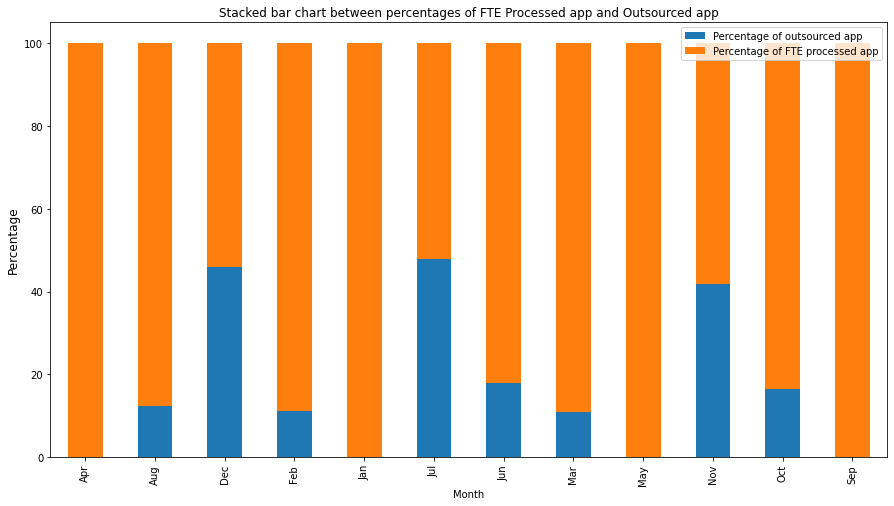

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
df_M = Output_M_df[['Month', 'Demand', 'Outsourced_App',"FTE_Applications"]].groupby(['Month']).sum()
df_M["Percentage of outsourced app"] = df_M['Outsourced_App']/df_M['Demand']*100
df_M['Percentage of FTE processed app'] = df_M['FTE_Applications']/df_M['Demand']*100
ax = df_M[['Percentage of outsourced app','Percentage of FTE processed app']].plot(kind='bar', stacked=True, figsize=(15,8))
ax.set_ylabel("Percentage", fontsize=12)
plt.title("Stacked bar chart between percentages of FTE Processed app and Outsourced app", fontsize=12)
plt.show()

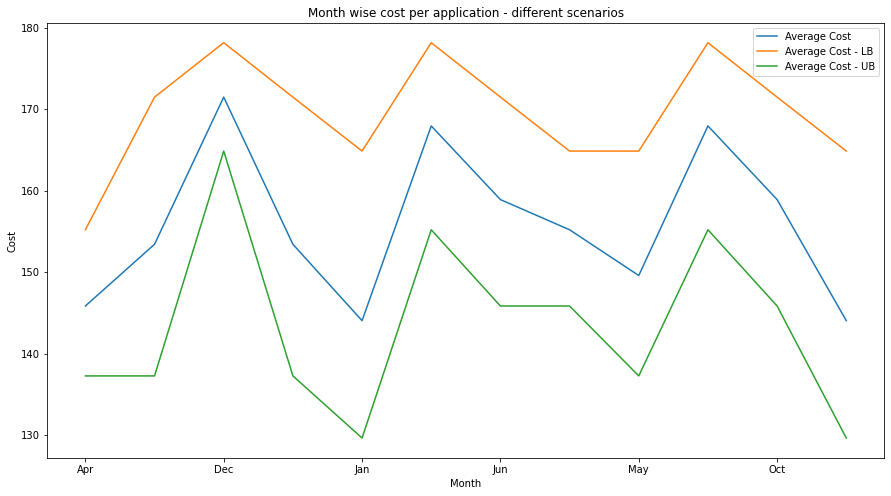

In [81]:
df_mix = pd.concat([Output_M_df[['Average Cost','Month']], Output_LB_df[['Average Cost - LB']], Output_UB_df[['Average Cost - UB']]], axis=1)
df_mix = df_mix.groupby(['Month']).mean()
df_mix.plot.line(figsize=[15,8])
plt.xlabel("Month")
plt.ylabel("Cost")
plt.title("Month wise cost per application - different scenarios")
plt.show()